In [1]:
from huggingface_hub import notebook_login
from datasets import load_dataset, Dataset

In [2]:
import torch

from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, TrainingArguments, \
    PreTrainedModel
from peft import LoraConfig, PeftModel
from trl import SFTTrainer
from trl.trainer import ConstantLengthDataset

# from torchinfo import summary


In [3]:
import os
import time

In [4]:
# notebook_login()

In [5]:
eli5: Dataset = load_dataset("eli5_category", split="train[:5000]", trust_remote_code=True)

In [6]:
eli5_train_test = eli5.train_test_split(test_size=0.2)

In [7]:
# eli5_train_test["train"][0]

In [8]:

model_id = "google/gemma-2b"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,#todo explore whether it actually increases overall memory usage to change this to float32
    bnb_4bit_use_double_quant=True# reminder that this makes computing the total memory used by the frozen weights even more complicated, something about reducing the size of the quantization constants that are used for remembering how to dequantize a given block of quantized weights? by the equivalent of 0.4 bits per parameter, per docs
)


lora_config = LoraConfig(
    r=64,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", # just lora'ing attention heads for now, to mimic original LoRA paper
                    "gate_proj", "up_proj", "down_proj"
                    ],# reminder, can use "all-linear" (not inside list) for the expansive case https://huggingface.co/docs/peft/developer_guides/lora#qlora-style-training
    task_type="CAUSAL_LM",
    use_rslora=True
    #todo investigate whether it's worth trying Dora, iirc that was said to be especially helpful when lora rank is low
)

seq_len = 128


In [9]:

eli5_train_test = eli5_train_test.flatten()

def fix_data(record):
    '''
    make dataset usable by TRL (i.e. its classes have a dataset_text_field param, and that column must be string-type,
    not list<string> type)
    :param record: record where the text column is actually a length-1 list column
    :return: record where the text column is straightforwardly a text-type column
    '''
    record["answers.text"] = record["answers.text"][0]
    return record

eli5_train_test = eli5_train_test.map(fix_data)

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [10]:
tokenizer = AutoTokenizer.from_pretrained(model_id)
# tokenizer.padding_side = "right" #todo based on runtime warning while building SFTTrainer, can try this if problems occur, but by default I think I should respect the default for the Gemma Tokenizer

fixed_len_train_dset =  ConstantLengthDataset(tokenizer, eli5_train_test["train"], "answers.text", seq_length=seq_len)
fixed_len_eval_dset =  ConstantLengthDataset(tokenizer, eli5_train_test["test"], "answers.text", seq_length=seq_len)


In [11]:
torch.cuda.memory.get_allocator_backend()

'native'

In [12]:
# os.environ["PYTORCH_NO_CUDA_MEMORY_CACHING"] = "1"
#the above completely breaks the visualization (somehow the graph seems to say that tens of gigabytes of ram are being used, but I'm running it on just 8gb vram gpu)

In [13]:
#todo try messing with PYTORCH_CUDA_ALLOC_CONF to make memory profiles more understandable
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "backend:cudaMallocAsync"
#todo try using cudaMallocAsync instead of pytorch native for backend


#todo, if cudamallocasync doesn't make things clearer, switch back to pytorch native backend but mess with roundup_power2_divisions option
# maybe try [128:32,256:32,512:64,1024:128,2048:256] so hopefuly things get broken down at 4mib granularity


In [14]:
torch.cuda.memory.get_allocator_backend()

'native'

In [15]:
torch.cuda.empty_cache()
print("gpu memory usage after clearing cache is " + torch.cuda.memory_summary(torch.device("cuda:0")))

gpu memory usage after clearing cache is |===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool

In [16]:
torch.cuda.memory._record_memory_history()

In [17]:
# print("start loading model at " + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
# test_model : PreTrainedModel = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map="auto")
# print("finish loading model at " + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

In [18]:
# print("printing modules in model")
# print(test_model.modules().__next__())

In [19]:
# lora_model = PeftModel(test_model, lora_config)

In [20]:
# print("printing modules in lora model")
# print(lora_model.modules().__next__())

In [21]:
with torch.profiler.profile(
        with_modules=True,
         with_stack=True,
        profile_memory=True,
        record_shapes=True
                            ) as prof:
    print("start loading model at " + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    model : PreTrainedModel = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map="auto")
    print("finish loading model at " + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

    print("printing modules in model")
    print(model.modules().__next__())
    # for module_name in model.modules():# might revisit this if other models besides gemma 2b don't have such a nicely descriptive first model, but unlikely
    #     print(module_name)
    #print("summary of model:")
    #print(summary(model, input_size=(256128, seq_len), device=None, depth=10, col_names=["input_size", "output_size", "num_params", "kernel_size", "trainable"]))
    # if try torchinfo again, experiment here with input_data=fixed_len_train_dset.dataset or something

    print("start creating trainer at " + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    trainer = SFTTrainer(
        model=model,
        train_dataset=fixed_len_train_dset,
        eval_dataset=fixed_len_eval_dset,
        args=TrainingArguments(
            per_device_train_batch_size=1,
            # gradient_accumulation_steps=4,#todo don't want to touch this until I understand it
            warmup_steps=2,
            max_steps=10,
            learning_rate=2e-4,
            fp16=True,
            logging_steps=1,
            output_dir="outputs",
            optim="paged_adamw_32bit"#can try paged_adamw_8bit in absolute worst case
        ),
        packing=True,
        # dataset_text_field="answers.text",
        peft_config=lora_config,
        max_seq_length=seq_len
    )
    print("finish creating trainer at " + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

    print("start training at " + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    trainer.train()
    print("finish training at " + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))


STAGE:2024-04-21 19:51:27 216421:216421 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


start loading model at 2024-04-21 19:51:27


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

finish loading model at 2024-04-21 19:51:31
printing modules in model
GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear4bit(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): 

/home/scostesal/.virtualenvs/local-finetuning-calculator/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:318: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(
/home/scostesal/.virtualenvs/local-finetuning-calculator/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/home/scostesal/.virtualenvs/local-fi

finish creating trainer at 2024-04-21 19:51:32
start training at 2024-04-21 19:51:32


Step,Training Loss
1,6.266700
2,4.550400
3,4.727400
4,5.213700
5,6.094300
6,4.203900
7,4.484400
8,4.989100
9,3.866000
10,4.246600


finish training at 2024-04-21 19:51:40


STAGE:2024-04-21 19:51:45 216421:216421 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-04-21 19:51:45 216421:216421 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [22]:
os.getcwd()

'/mnt/c/Users/ssili/PycharmProjects/local-finetuning-calculator'

In [23]:
result_files_ts_str = time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime())

print("about to dump memory snapshot at " + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
torch.cuda.memory._dump_snapshot(f"gemma2b_mem_snapshot_{result_files_ts_str}.pickle")
print("finished dumping memory snapshot at " + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

about to dump memory snapshot at 2024-04-21 19:52:20


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

finished dumping memory snapshot at 2024-04-21 19:52:24


about to dump memory timeline summary json at 2024-04-21 19:52:24
finished dumping memory timeline summary json and about to dump memory timeline details/raw json at 2024-04-21 19:56:16
finished dumping memory timeline details/raw json and about to dump memory timeline static visualization at 2024-04-21 20:00:09
finished dumping memory timeline static visualization about to create nicer (I think interactive) visualization of memory profiling at 2024-04-21 20:04:53


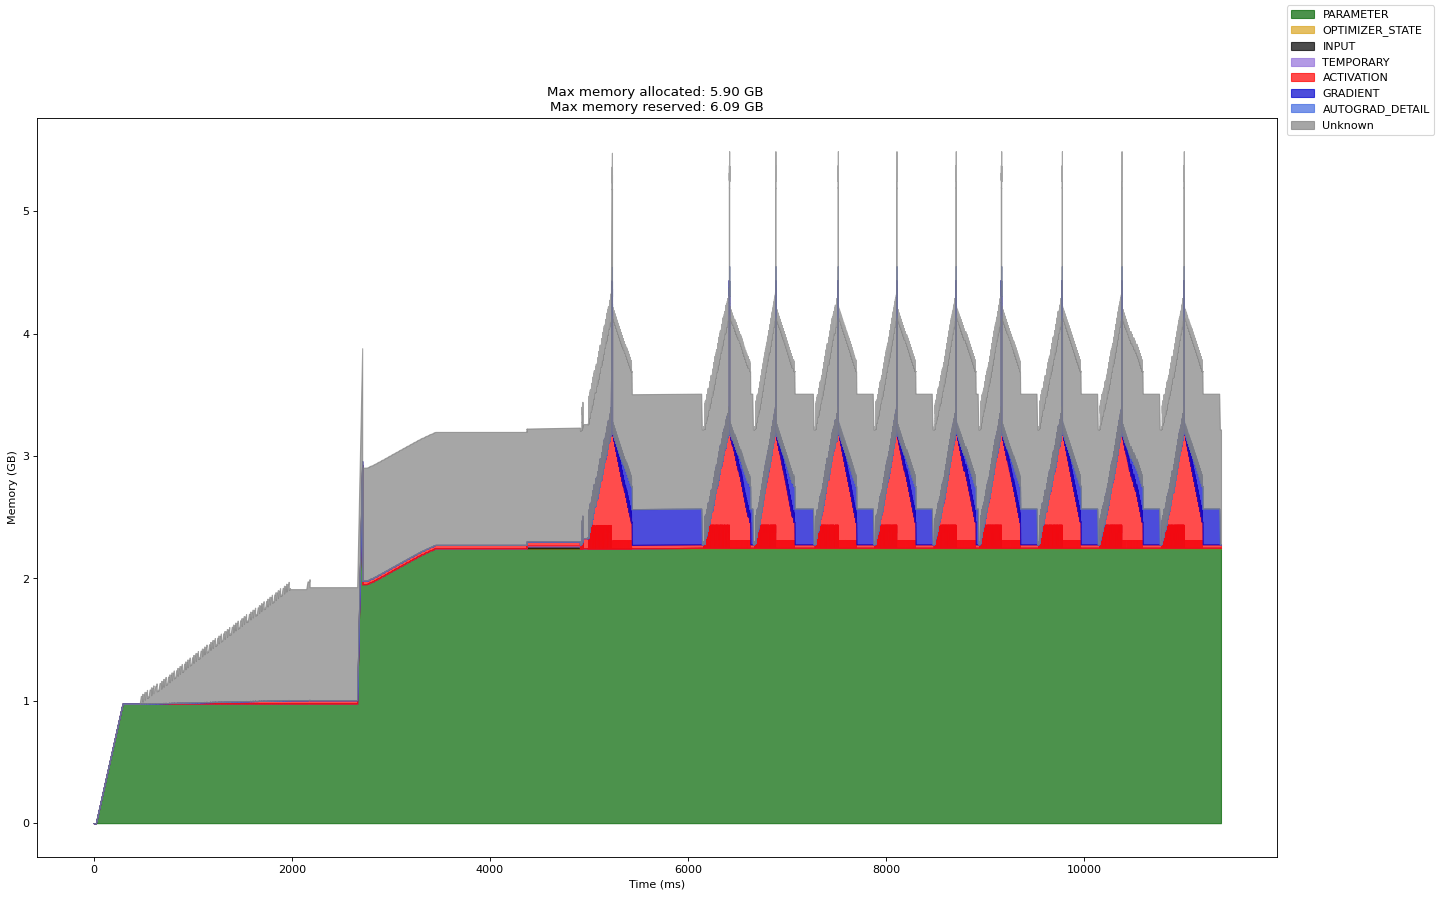

In [24]:
print("about to dump memory timeline summary json at " + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
prof.export_memory_timeline(f"gemma2b_mem_timeline_summary_{result_files_ts_str}.json")
print("finished dumping memory timeline summary json and about to dump memory timeline details/raw json at " + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
prof.export_memory_timeline(f"gemma2b_mem_timeline_details_{result_files_ts_str}.raw.json")
print("finished dumping memory timeline details/raw json and about to dump memory timeline static visualization at " + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
prof.export_memory_timeline(f"gemma2b_mem_timeline_static_viz_{result_files_ts_str}.html")
print("finished dumping memory timeline static visualization about to create nicer (I think interactive) visualization of memory profiling at " + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

In [25]:
print("about to start creating visualization of memory profiling at " + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

from torch.cuda._memory_viz import profile_plot
with open(f'gemma2b_mem_profile_{result_files_ts_str}.html', 'w') as f:
    f.write(profile_plot(prof))

    #when with_stack, profile_memory, and record_shapes were all True; and dataset size was 5k (leading to 10 hills in memory snapshot- 10 epochs):
    # profile_plot() ran for almost 3 hours and then was killed (by the wsl shell? by the python interpreter? not sure)

    # when I tried setting with_stack and record_shapes to False to hopefully speed it up, I got error that memory profiling requires them. oops
print("finished creating visualization of memory profiling at " + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

about to start creating visualization of memory profiling at 2024-04-21 20:04:54
finished creating visualization of memory profiling at 2024-04-21 20:10:11


In [26]:
torch.cuda.memory._record_memory_history(enabled=None)